In [24]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from topostats.io import LoadScans
import topostats.filters as topofilters
from skimage.filters import threshold_otsu
from topostats.utils import get_mask
from skimage.filters import gaussian
from skimage.morphology import remove_small_objects, label
from skimage.measure import regionprops
from skimage import draw
from skimage import util
from topostats.theme import Colormap
import math
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max

In [3]:
cmap = Colormap("nanoscope").get_cmap()
def plot(image: np.ndarray, title: str=None, zlimit: bool=True, figsize: tuple=(8, 8), **kwargs) -> None:
    fig, ax = plt.subplots(figsize=figsize)
    if zlimit == True:
        vmin=-3
        vmax=4
    else:
        vmin=None
        vmax=None
    ax.imshow(image, vmin=vmin, vmax=vmax, cmap=cmap, **kwargs)
    if title is not None:
        ax.set_title(title)
    plt.show()

[Thu, 24 Aug 2023 15:03:05] [INFO    ] [topostats] Extracting image from PristineZoom\Mid\20230417_KPN0018_Metal.0_00005.spm
[Thu, 24 Aug 2023 15:03:05] [INFO    ] [topostats] Loading image from : PristineZoom\Mid\20230417_KPN0018_Metal.0_00005.spm
[Thu, 24 Aug 2023 15:03:05] [INFO    ] [topostats] [20230417_KPN0018_Metal.0_00005] : Loaded image from : PristineZoom\Mid\20230417_KPN0018_Metal.0_00005.spm
[Thu, 24 Aug 2023 15:03:05] [INFO    ] [topostats] [20230417_KPN0018_Metal.0_00005] : Extracted channel Height
[Thu, 24 Aug 2023 15:03:05] [INFO    ] [topostats] [20230417_KPN0018_Metal.0_00005] : Pixel to nm scaling : 4.150390625
4.150390625


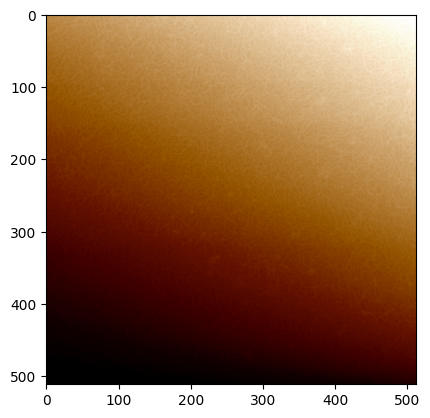

In [45]:
#Import SPM files
#file = Path('./PristineZoom/20230125_KPN005_25mMMgCl2_Vac.0_00009.spm')
#file = Path('./PristineZoom/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00006.spm')
#file = Path('./EP_Zoom/20230419_EPN005_Metal.0_00006.spm')
file = Path('./PristineZoom/Mid/20230417_KPN0018_Metal.0_00005.spm')

loadscans = LoadScans([file], 'Height')
loadscans.get_data()
p_to_nm = loadscans.pixel_to_nm_scaling
image_raw = loadscans.image
plt.imshow(image_raw, cmap=cmap)
print(p_to_nm)

In [5]:
filters = topofilters.Filters(
    image = image_raw,
    filename = file,
    pixel_to_nm_scaling = p_to_nm,
    threshold_method='std_dev',
    row_alignment_quantile=0.05,
    threshold_std_dev={'upper': 1.0, 'lower': None},
    gaussian_size=1.0,
    remove_scars={'run': False}
)

filters.filter_image()

[Thu, 24 Aug 2023 13:56:18] [INFO    ] [topostats] [PristineZoom\Mid\20230417_KPN0018_Metal.0_00005.spm] : Median flattening without mask
[Thu, 24 Aug 2023 13:56:18] [INFO    ] [topostats] [PristineZoom\Mid\20230417_KPN0018_Metal.0_00005.spm] : Plane tilt removal without mask
[Thu, 24 Aug 2023 13:56:18] [INFO    ] [topostats] [PristineZoom\Mid\20230417_KPN0018_Metal.0_00005.spm] : x-polyfit 1st order: [ 0.03915974 -1.05113753]
[Thu, 24 Aug 2023 13:56:18] [INFO    ] [topostats] [PristineZoom\Mid\20230417_KPN0018_Metal.0_00005.spm] : y-polyfit 1st order: [6.50838842e-05 8.90912711e+00]
[Thu, 24 Aug 2023 13:56:18] [INFO    ] [topostats] [PristineZoom\Mid\20230417_KPN0018_Metal.0_00005.spm] : Removing x plane tilt
[Thu, 24 Aug 2023 13:56:19] [INFO    ] [topostats] [PristineZoom\Mid\20230417_KPN0018_Metal.0_00005.spm] : removing y plane tilt
[Thu, 24 Aug 2023 13:56:19] [INFO    ] [topostats] [PristineZoom\Mid\20230417_KPN0018_Metal.0_00005.spm] : Remove quadratic bow without mask
[Thu, 24 A

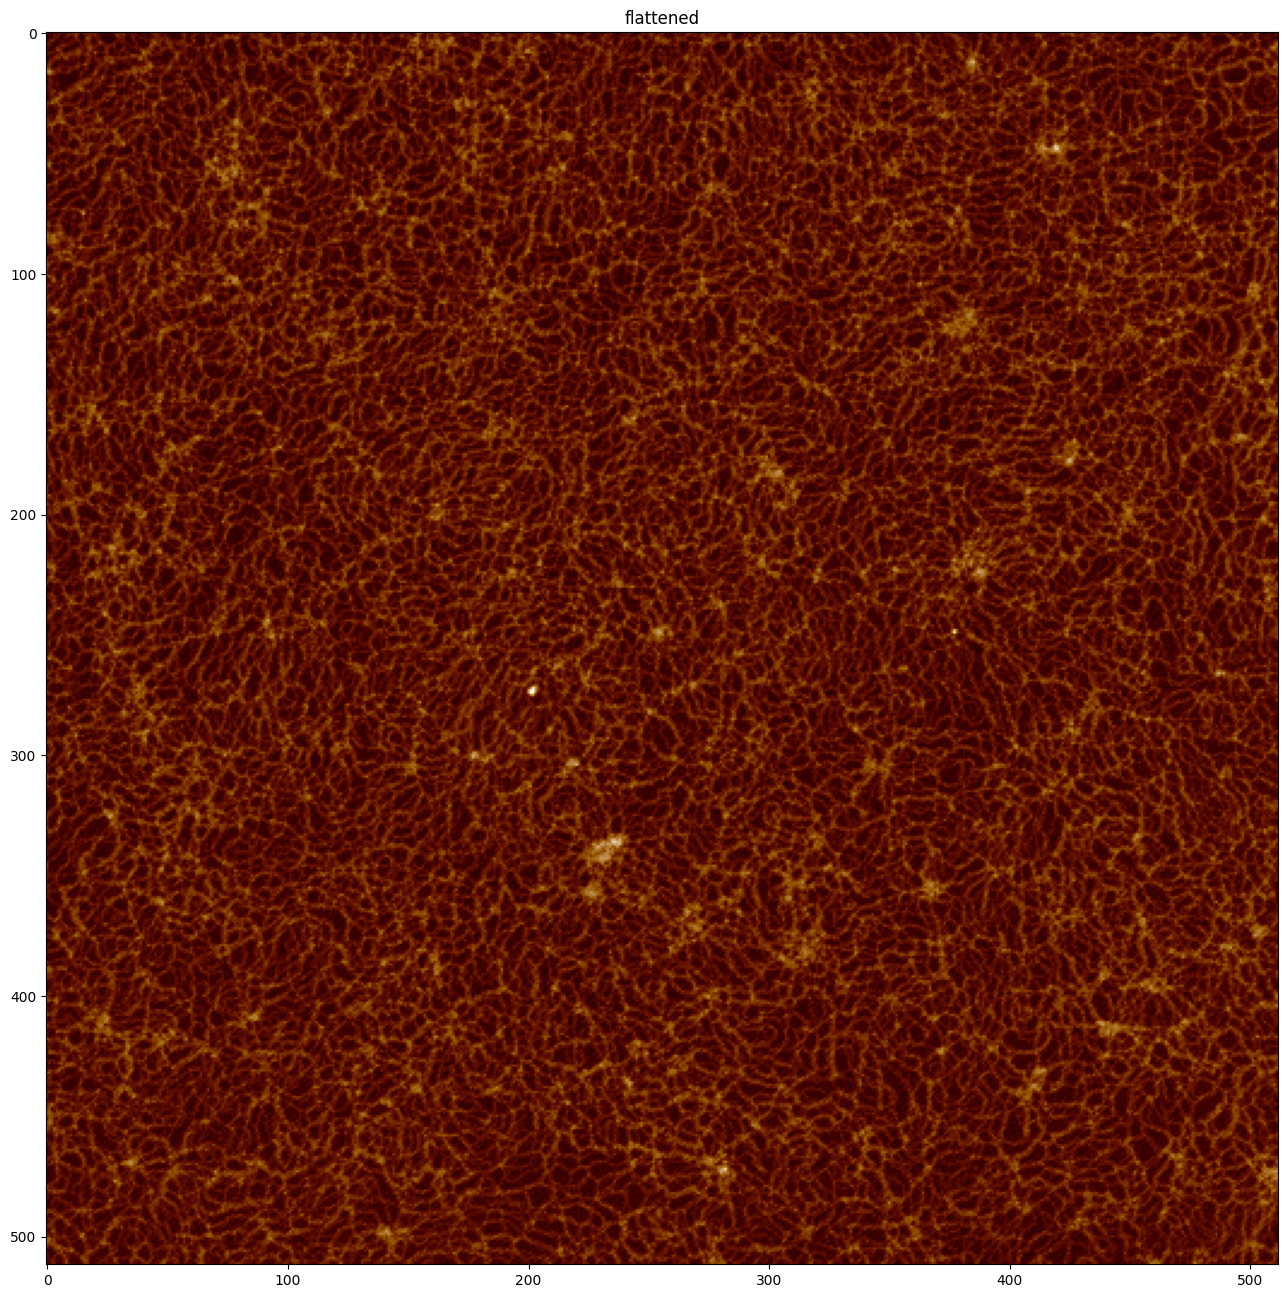

In [46]:
flattened = filters.images['zero_average_background']
plot(flattened, title='flattened',figsize=(16,16))

thresholds: defaultdict(None, {'upper': 0.14750762136181816})
[Thu, 24 Aug 2023 15:31:48] [INFO    ] [topostats] [None] : Masking (upper) Threshold: 0.14750762136181816


C:\Users\bdigg\AppData\Local\Temp\ipykernel_16864\2788156702.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  otsu_threshold_multiplier=np.float(1)


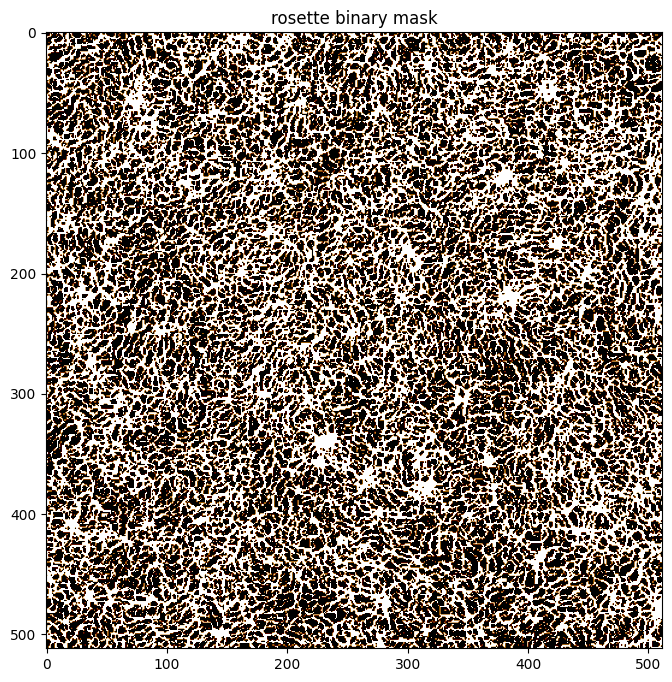

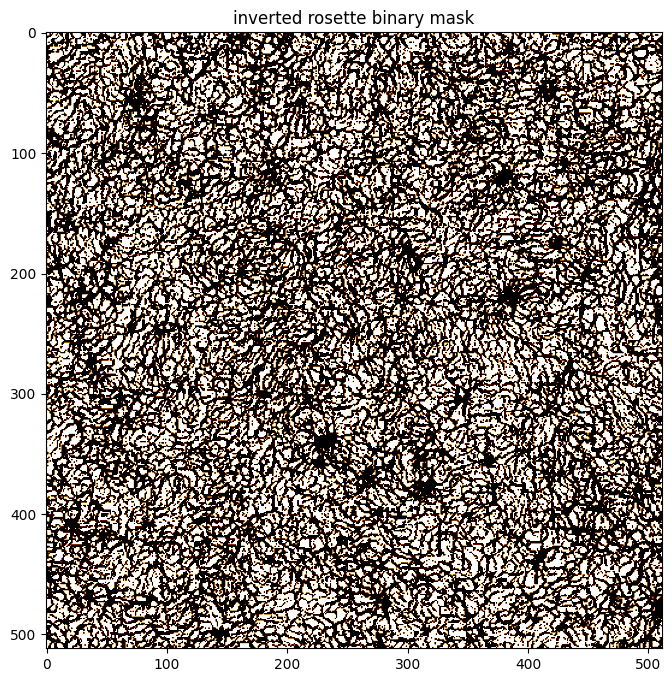

In [70]:
#Threshold

strand_thresholds = topofilters.get_thresholds(
    flattened,
    threshold_method='otsu',
    otsu_threshold_multiplier=np.float(1)
)

print(f'thresholds: {strand_thresholds}')
strand_mask = topofilters.get_mask(image=flattened, thresholds=strand_thresholds)
plot(strand_mask.astype(bool), title='rosette binary mask', zlimit=False)
grain_mask = util.invert(strand_mask)
plot(grain_mask.astype(bool), title='inverted rosette binary mask', zlimit=False)



In [71]:
# Remove small objects (smaller than strand squared)
removed_small_objects = remove_small_objects(grain_mask, (36/p_to_nm))
# Remove large objects
labelled_grain_mask = label(grain_mask)
regions = regionprops(labelled_grain_mask)
for props_index, props in enumerate(regions):
    if props.area > 100000:
        labelled_grain_mask[labelled_grain_mask==props.label] = 0

In [72]:
distance = ndi.distance_transform_edt(labelled_grain_mask)
coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=labelled_grain_mask)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
grains = watershed(-distance, markers, mask=labelled_grain_mask, connectivity=0)


Text(0.5, 1.0, 'Separated objects')

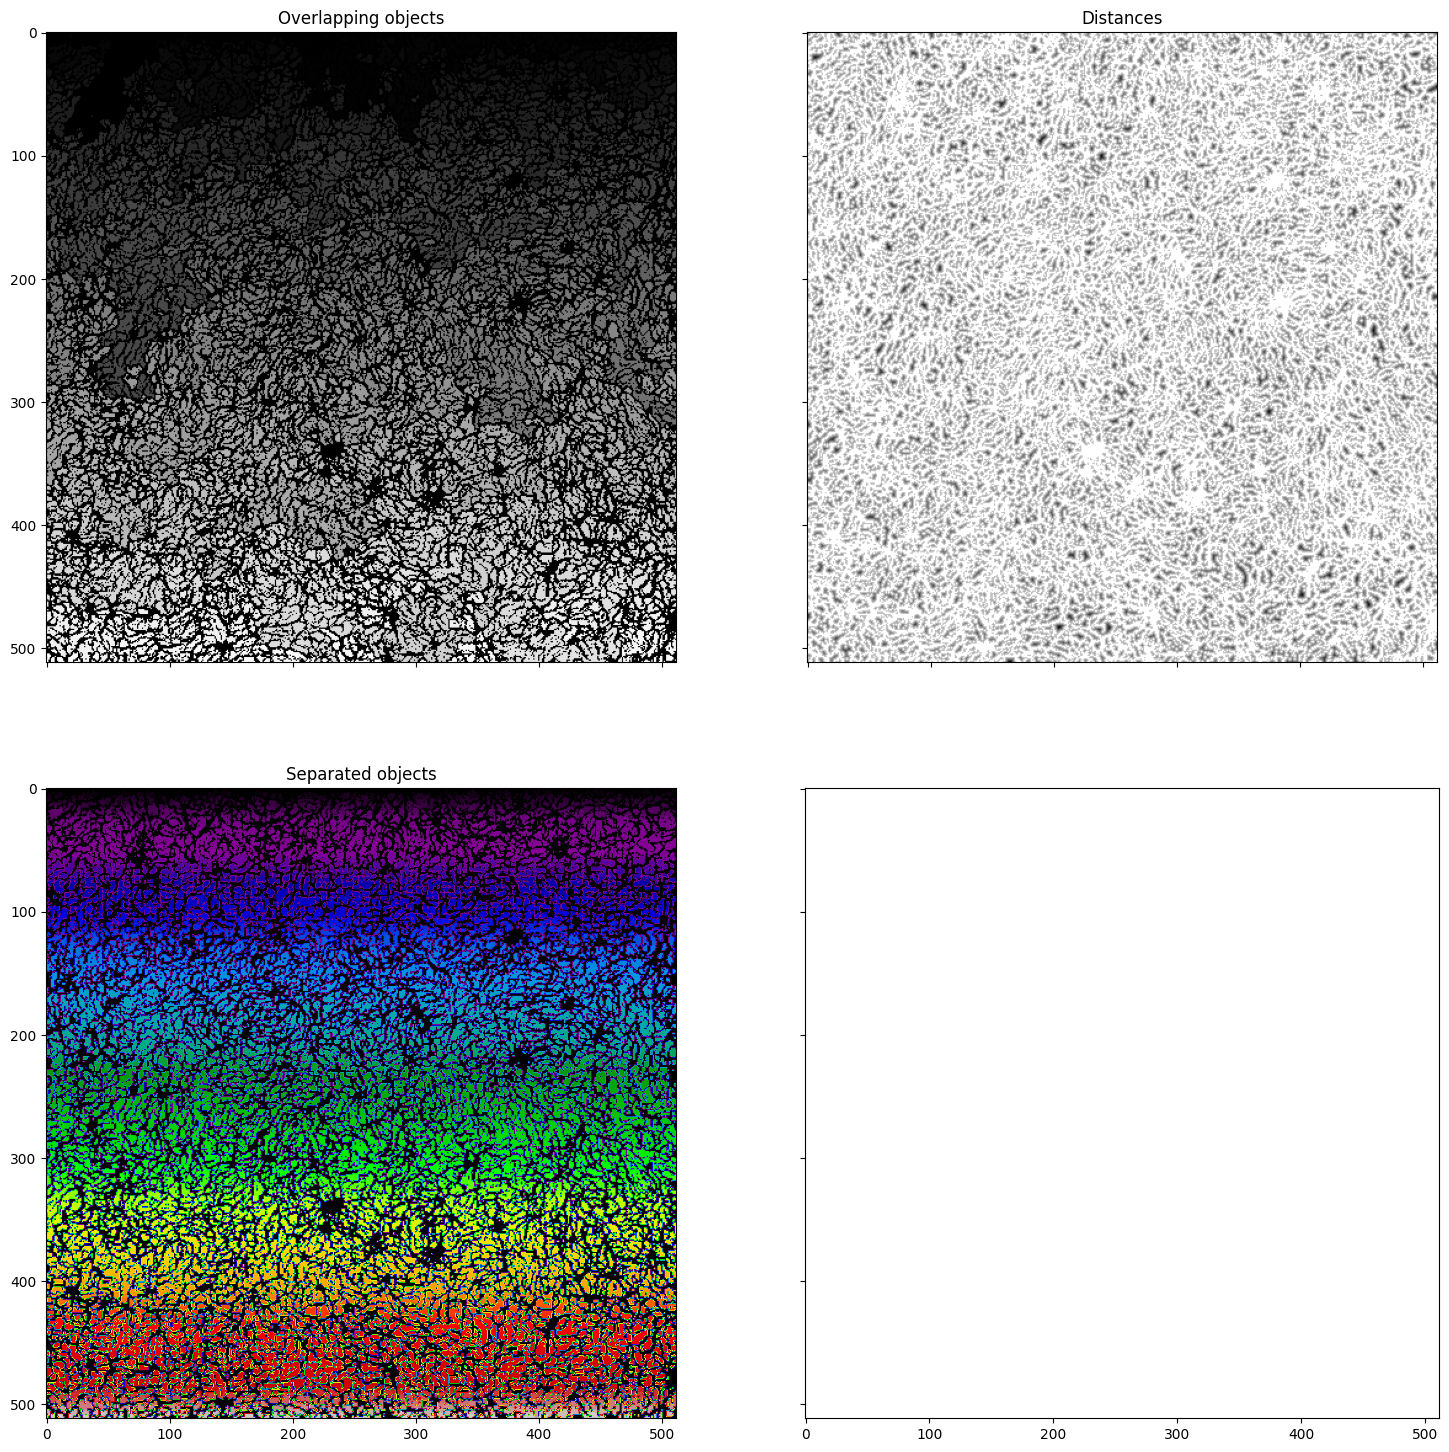

In [73]:
fig, axes = plt.subplots(ncols=2,nrows=2,figsize=(18, 18), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(labelled_grain_mask, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(grains, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')
#ax[3].imshow(grains[1], cmap=plt.cm.nipy_spectral)
#ax[3].set_title('Separated objects filtered')


In [74]:
region_props = regionprops(grains)
areas = np.zeros(len(region_props))

for props_index, props in enumerate(region_props):
        areas[props_index] = props.area
areas_nm = areas*p_to_nm
diameter_nm = np.sqrt(areas_nm)
print("Mean Pore Area: ",np.mean(areas_nm))
print("Median Pore Area: ",np.median(areas_nm))
print("Mean Pore Diameter: ",np.mean(diameter_nm))
print("Median Pore Diameter: ",np.median(diameter_nm))


Mean Pore Area:  28.84858789041751
Median Pore Area:  20.751953125
Mean Pore Diameter:  4.881105455269135
Median Pore Diameter:  4.555431167847891


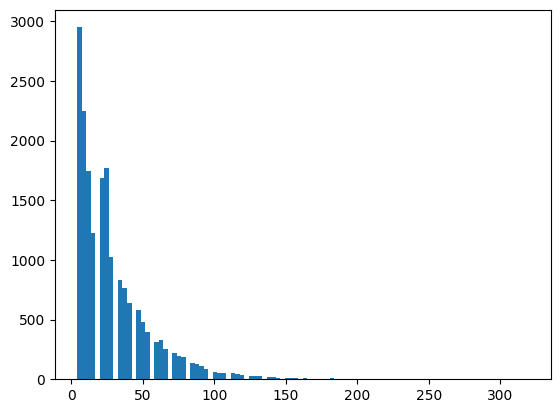

In [75]:
fig, ax = plt.subplots()
ax.hist(areas_nm, bins=100)
plt.show()

In [76]:

# Remove small objects
removed_small_objects = remove_small_objects(grains, 1)
# Remove large objects
labelled_grain_mask = label(removed_small_objects)
regions = regionprops(labelled_grain_mask)
for props_index, props in enumerate(regions):
    if props.area > 25:
        labelled_grain_mask[labelled_grain_mask==props.label] = 0